# This notebook is about learning data analysis using Python #
## Focus is model evaluation and refinement ##
### NB: This notebook follows a previous notebook about model development ###

### Step 1 : importing and selecting numeric data only ###

In [1]:
import pandas as pd
import numpy as np

# Import clean data 
path = 'https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DA0101EN/module_5_auto.csv'
df = pd.read_csv(path)

# Select numeric data
df=df._get_numeric_data()
df.head()


,Unnamed: 0,Unnamed: 0.1,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,...,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,city-L/100km,diesel,gas
0,0,0,3,122,88.6,0.811148,0.890278,48.8,2548,130,...,2.68,9.0,111.0,5000.0,21,27,13495.0,11.190476,0,1
1,1,1,3,122,88.6,0.811148,0.890278,48.8,2548,130,...,2.68,9.0,111.0,5000.0,21,27,16500.0,11.190476,0,1
2,2,2,1,122,94.5,0.822681,0.909722,52.4,2823,152,...,3.47,9.0,154.0,5000.0,19,26,16500.0,12.368421,0,1
3,3,3,2,164,99.8,0.848630,0.919444,54.3,2337,109,...,3.40,10.0,102.0,5500.0,24,30,13950.0,9.791667,0,1
4,4,4,2,164,99.4,0.848630,0.922222,54.3,2824,136,...,3.40,8.0,115.0,5500.0,18,22,17450.0,13.055556,0,1


In [2]:
# import a selection of display libraries

# %%capture
# ! pip install ipywidgets
# from IPython.display import display
# from IPython.html import widgets 
# from IPython.display import display
# from ipywidgets import interact, interactive, fixed, interact_manual


UsageError: Line magic function `%%capture` not found.


### Step 2 : Prepare functions for plotting ###

In [2]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('Price (in dollars)')
    plt.ylabel('Proportion of Cars')

    plt.show()
    plt.close()
    
def PollyPlot(xtrain, xtest, y_train, y_test, lr,poly_transform): #training data, testing data,lr =linear regression object,
    #poly_transform = polynomial transformation object
    width = 12
    height = 10
    plt.figure(figsize=(width, height))
    
    xmax=max([xtrain.values.max(), xtest.values.max()])
    xmin=min([xtrain.values.min(), xtest.values.min()])
    x=np.arange(xmin, xmax, 0.1)

    plt.plot(xtrain, y_train, 'ro', label='Training Data')
    plt.plot(xtest, y_test, 'go', label='Test Data')
    plt.plot(x, lr.predict(poly_transform.fit_transform(x.reshape(-1, 1))), label='Predicted Function')
    plt.ylim([-10000, 60000])
    plt.ylabel('Price')
    plt.legend()    

### Step 3 : Training and testing ###

An important step in testing the model is to split the data into training and testing data. We will place the target data price in a separate dataframe y.

In [3]:
y_data = df['price']

# Let's then attribute the dataframe df to x_data and drop price data as they will be predicted with y_data.

x_data=df.drop('price',axis=1)


We then randomly split our data into training and testing data using the function train_test_split.

In [4]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15, random_state=1)

print("number of test samples :", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples : 31
number of training samples: 170


The test_size parameter sets the proportion of data that is split into the testing set. In the above, the testing set is set to 15% of the total dataset that, we know, contains 201 rows.

Let's now check the R^2 of the feature horsepower on test and train data

In [5]:
from sklearn.linear_model import LinearRegression

lre=LinearRegression() # Create a linear regression object
lre.fit(x_train[['horsepower']], y_train) # Fit the model using the feature horsepower

print("test R^2 is:" ,lre.score(x_test[['horsepower']], y_test)) # Calculate R^2 on test data
print ("train R^2 is:" ,lre.score(x_train[['horsepower']], y_train)) # Calculate R^2 on train data

test R^2 is: 0.707688374146705
train R^2 is: 0.6449517437659684


We can see that the R^2 of test data is higher than the R^2 of train data.

We can run a similar check with a reduced testing set of 10% of the data and compare the results:

In [6]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_data, y_data, test_size=0.1, random_state=0)

lre.fit(x_train1[['horsepower']],y_train1)

print("test R^2 is:" ,lre.score(x_test1[['horsepower']], y_test1)) # Calculate R^2 on test data
print ("train R^2 is:" ,lre.score(x_train1[['horsepower']], y_train1)) # Calculate R^2 on train data

test R^2 is: 0.7340722810055448
train R^2 is: 0.6479796296498318


### Step 4 : Overfitting, underfitting and model selection ###

It turns out that the test data sometimes referred to as the out of sample data is a much better measure of how well the model performs in the real world. One reason for this is overfitting. These differences are more apparent in Multiple Linear Regression and Polynomial Regression so we will explore overfitting in that context.

Let's create Multiple linear regression objects and train the model using 'horsepower', 'curb-weight', 'engine-size' and 'highway-mpg' as features.

In [10]:
from sklearn.model_selection import cross_val_score

lr = LinearRegression()
lr.fit(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_train)

# Prediction using training data:

yhat_train = lr.predict(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])
print (yhat_train[0:5])

# Prediction using test data:
    
yhat_test = lr.predict(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])
print (yhat_test[0:5])   

[11927.70699817 11236.71672034  6436.91775515 21890.22064982
 16667.18254832]
[11349.16502418  5914.48335385 11243.76325987  6662.03197043
 15555.76936275]


Let's perform some model evaluation using our training and testing data separately. We can look at the distribution of the predicted values of the training data.

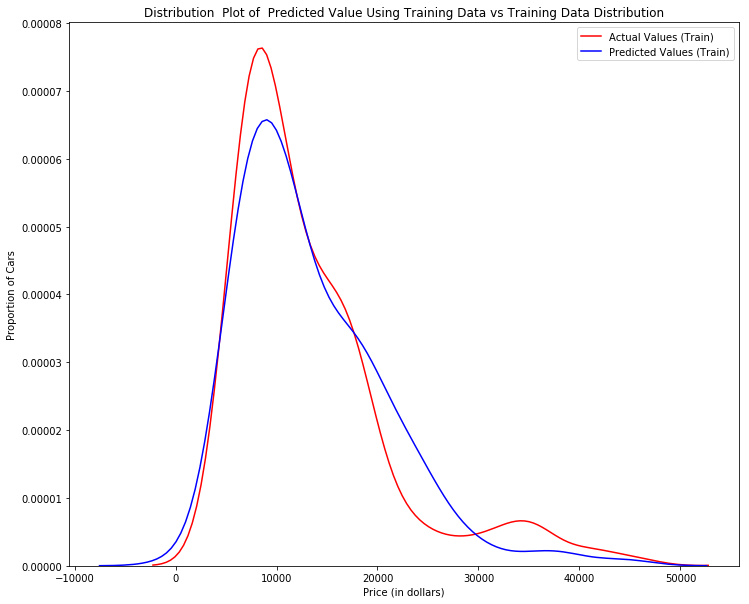

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Title = 'Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_train, yhat_train, "Actual Values (Train)", "Predicted Values (Train)", Title)